In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import pickle
from copy import deepcopy
from math import sqrt, ceil
import datetime
import sys
from itertools import product
import pandas as pd
import json

from data_utils import load_cfar10_batch, load_label_names
from losses import CategoricalHingeLoss, CategoricalCrossEntropyLoss, Loss
from activations import LinearActivation, ReLUActivation, SoftmaxActivation
from initializers import NormalInitializer, XavierInitializer
from layers import Dense
from regularizers import L2Regularizer
from models import Model
from metrics import AccuracyMetrics, Metrics
from optimizers import SGDOptimizer
from lr_schedules import LRConstantSchedule, LRExponentialDecaySchedule, LRCyclingSchedule

In [2]:
def plot_losses(history):
    plt.plot(history["loss_train"], label="train")
    plt.plot(history["loss_val"], label="val")
    plt.grid()
    plt.title("Loss vs. epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    path = "losses.png"
    plt.savefig(path)
    plt.show()
    
def plot_costs(history):
    plt.plot(history["cost_train"], label="train")
    plt.plot(history["cost_val"], label="val")
    plt.grid()
    plt.title("Cost vs. epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Cost")
    plt.legend()
    path = "costs.png"
    plt.savefig(path)
    plt.show()
    
def plot_accuracies(history):
    plt.plot(history["accuracy_train"], label="train")
    plt.plot(history["accuracy_val"], label="val")
    plt.grid()
    plt.title("Accuracy vs. epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    path = "accuracies.png"
    plt.savefig(path)
    plt.show()
    
def plot_lr(history):
    plt.plot(history["lr"], label="lr")
    plt.grid()
    plt.title("Learning rate vs. epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Learning rate")
    plt.legend()
    path = "lrs.png"
    plt.savefig(path)
    plt.show()

In [80]:
class MeanSquaredErrorLoss(Loss):

    def __init__(self, ):
        name = "mse"
        super().__init__(name)

    def compute_loss(self, scores, y):
        """ Computes loss of classifier - also includes the regularization losses from previous layers.

        Parameters
        ----------
        scores : numpy.ndarray
            Scores. Usually from softmax activation.
            Shape is (batch size, )
        y : numpy.ndarray
            True labels.
            Shape is (batch size, )

        Returns
        -------
        loss : float
            The overall loss of the classifier.

        Notes
        -----
        None
        """
        #self.cache["g"] = deepcopy(y)
        n = y.shape[0]
        loss = np.mean(np.square((y - scores)))
        
        self.cache["g"] = 2*(scores - y)
        
        return loss

    def grad(self, ):
        """ Computes the gradient of the loss function.

        Parameters
        ----------
        None

        Returns
        -------
        numpy.ndarray or None
            None if gradient has not yet been computed.
            Shape of gradient is (batch size, ). Note that the grad here is just y.

        Notes
        -----
        None
        """
        if "g" in self.cache.keys():
            return deepcopy(self.cache["g"])
        else:
            return None

In [81]:
class MeanSquaredErrorMetrics(Metrics):
    """ Accuracy metrics class.

    Attributes
    ----------
    name : str
        The name of the metric.

    Methods
    -------
    __init__()
        Constuctor.
    """

    def __init__(self, ):
        """ Constructor.

        Parameters
        ----------
        None

        Notes
        -----
        None
        """
        super().__init__()
        self.name = "mse metrics"

    def compute(self, y, scores):
        """ Computes the accuracy of inferred numerical labels when compared to their true counterparts.

        Parameters
        ----------
        y : numpy.ndarray
            True labels.
            Shape is (number of data points, )
        scores : numpy.ndarray
            Activation of last layer of the model - the scores of the network.
            Shape is (batch_size, out_dim) where out_dim is the output
            dimension of the last layer of the model - usually same as
            the number of classes.

        Returns
        -------
        float
            The accuracy of inferred numerical labels when compared to their true counterparts.

        Notes
        -----
        None

        Raises
        ------
        AssertionError
            If y.shape is not the same as y_hat.shape
        """
        return np.mean(np.square((y - scores)))

(100, 1)


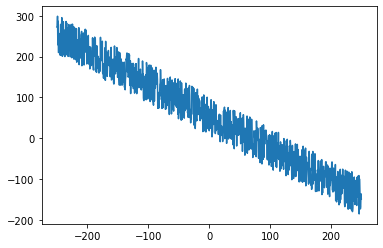

In [86]:
# Generate data with linear trend.
import random
n_data = 500

xs = np.array([float(x/2) for x in range(-n_data, n_data, 1)]).reshape(-1,1)
m = -0.8
b = 5
ys = np.array([x*m + b + 100 * random.random() for x in xs])

plt.plot(xs, ys)

x_train = xs[:800]
x_val = xs[800:900]
x_test = xs[900:]

y_train = ys[:800]
y_val = ys[800:900]
y_test = ys[900:]

print(y_test.shape)

model summary: 
layer 0: dense: 
	 shape -- in: 1, out: 5
	 w -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2), reg: None
	 b -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2)
	 activation: relu

layer 1: dense: 
	 shape -- in: 5, out: 1
	 w -- init: Xavier ~ 1.000000 x N(0.000000, 0.447214^2), reg: None
	 b -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2)
	 activation: linear

mse
sgd with constant lr schedule

starting epoch: 1 ...
batch 8/8: 100%|██████████| 8/8 [00:00<00:00, 404.67it/s]
epoch 1/10 
 	 -- train loss = 15842.250311040018 / train cost = 15842.250311040018
	 -- {"mse metrics_train": 15842.250311040018} 
	 -- val loss = 7308.029837531017 / val cost = 7308.029837531017
	 -- {"mse metrics_val": 7308.029837531017} 


starting epoch: 2 ...
batch 8/8: 100%|██████████| 8/8 [00:00<00:00, 585.45it/s]
epoch 2/10 
 	 -- train loss = 7505.712489003022 / train cost = 7505.712489003022
	 -- {"mse metrics_train": 7505.712489003022} 
	 -- val loss = 4100.353038970296 / val 

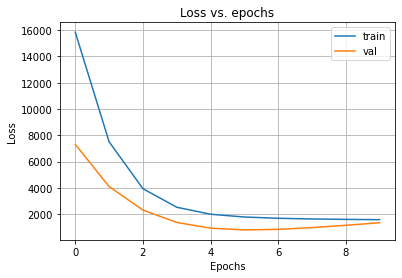

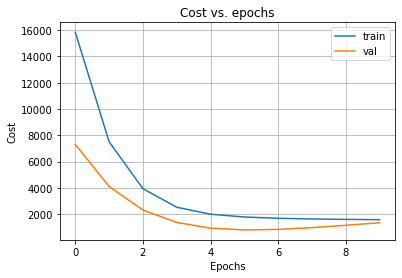

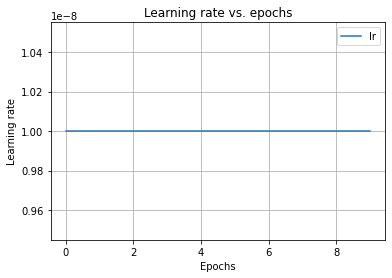

test metrics: {"mse metrics": 2578.07149724482}


In [87]:
coeff = 1.0
mean = 0.0
std = 0.001
params = {"coeff":coeff, "mean": mean, "std":None}

reg_rate_l2 = 0.01

in_dim = x_train.shape[1]
out_dim = 1
mid_dim = 5

seed = 200

dense_1 = \
    Dense(in_dim=in_dim, out_dim=mid_dim, 
          kernel_initializer=XavierInitializer(seed=seed, **params), 
          bias_initializer=XavierInitializer(seed=seed+1, **params), 
          kernel_regularizer=None, 
          activation=ReLUActivation()
         )

dense_2 = \
    Dense(in_dim=mid_dim, out_dim=out_dim,
          kernel_initializer=XavierInitializer(seed=seed+2, **params), 
          bias_initializer=XavierInitializer(seed=seed+3, **params), 
          kernel_regularizer=None, 
          activation=LinearActivation()
         )

layers = [
    dense_1,
    dense_2
]

model = Model(layers)

loss = MeanSquaredErrorLoss()

n_epochs = 10
batch_size = 100

lr_initial = 1e-8
lr_schedule = LRConstantSchedule(lr_initial)
optimizer = SGDOptimizer(lr_schedule=lr_schedule)

metrics = [MeanSquaredErrorMetrics()]

model.compile_model(optimizer, loss, metrics)
print(model)

verbose = 2
history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size, verbose)

plot_losses(history)
plot_costs(history)
#plot_accuracies(history)
plot_lr(history)

scores_test = model.forward(x_test)
#y_hat_test = np.argmax(scores_test, axis=1)
metrics_test = model.compute_metrics(y_test, scores_test)

print(f"test metrics: {json.dumps(metrics_test)}")

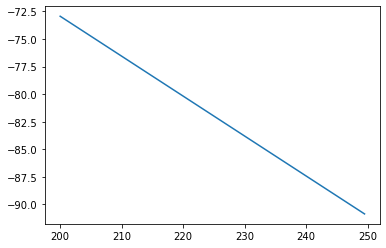

In [88]:
plt.plot(x_test, scores_test)

In [ ]:
coeff = 1.0
mean = 0.0
std = 0.01
params = {"coeff":coeff, "mean": mean, "std":None}

#reg_rate_l2 = 0.1
reg_rate_l2 = 0.025

in_dim = x_train.shape[1]
out_dim = 10
mid_dim = 50

seed = 200

dense_1 = \
    Dense(in_dim=in_dim, out_dim=mid_dim, 
          kernel_initializer=XavierInitializer(seed=seed, **params), 
          bias_initializer=XavierInitializer(seed=seed+1, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=ReLUActivation()
         )

dense_2 = \
    Dense(in_dim=mid_dim, out_dim=out_dim,
          kernel_initializer=XavierInitializer(seed=seed+2, **params), 
          bias_initializer=XavierInitializer(seed=seed+3, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=SoftmaxActivation()
         )

layers = [
    dense_1,
    dense_2
]

model = Model(layers)
loss = CategoricalCrossEntropyLoss()

n_epochs = 50
batch_size = 100

#lr_initial = 0.01
#lr_schedule = LRConstantSchedule(lr_initial)
#decay_steps = n_epochs * 2
#decay_rate = 0.9
#lr_schedule = LRExponentialDecaySchedule(lr_initial, decay_steps, decay_rate)

lr_initial = 1e-5
lr_max = 1e-1
step_size = 800
lr_schedule = LRCyclingSchedule(lr_initial, lr_max, step_size)
optimizer = SGDOptimizer(lr_schedule=lr_schedule)

metrics = [AccuracyMetrics()]

model.compile_model(optimizer, loss, metrics)
print(model)


history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size)

plot_losses(history)
plot_costs(history)
plot_accuracies(history)
plot_lr(history)

scores_test = model.forward(x_test)
#y_hat_test = np.argmax(scores_test, axis=1)
metrics_test = model.compute_metrics(y_test, scores_test)

print(f"test metrics: {json.dumps(metrics_test)}")

In [ ]:
coeff = 1.0
mean = 0.0
std = 0.01
params = {"coeff":coeff, "mean": mean, "std":None}

#reg_rate_l2 = 0.1
reg_rate_l2 = 0.025

in_dim = x_train.shape[1]
out_dim = 10
mid_dim = 50

seed = 200

dense_1 = \
    Dense(in_dim=in_dim, out_dim=mid_dim, 
          kernel_initializer=XavierInitializer(seed=seed, **params), 
          bias_initializer=XavierInitializer(seed=seed+1, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=ReLUActivation()
         )

dropout = Dropout(p=0.5)

dense_2 = \
    Dense(in_dim=mid_dim, out_dim=out_dim,
          kernel_initializer=XavierInitializer(seed=seed+2, **params), 
          bias_initializer=XavierInitializer(seed=seed+3, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=SoftmaxActivation()
         )

layers = [
    dense_1,
    dropout,
    dense_2
]

model = Model(layers)
print(model)

loss = CategoricalCrossEntropyLoss()

n_epochs = 50
batch_size = 100

#lr_initial = 0.01
#lr_schedule = LRConstantSchedule(lr_initial)
#decay_steps = n_epochs * 2
#decay_rate = 0.9
#lr_schedule = LRExponentialDecaySchedule(lr_initial, decay_steps, decay_rate)

lr_initial = 1e-5
lr_max = 1e-1
step_size = 800
lr_schedule = LRCyclingSchedule(lr_initial, lr_max, step_size)
optimizer = SGDOptimizer(lr_schedule=lr_schedule)

metrics = [AccuracyMetrics()]

model.compile_model(optimizer, loss, metrics)
history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size)

plot_losses(history)
plot_costs(history)
plot_accuracies(history)
plot_lr(history)


params = {"mode": "test", "seed": None}
y_hat_test, scores_test, cost_test, data_loss_test, layers_reg_loss_test = \
    model.predict(x_test, y_test, **params)
acc_test = AccuracyMetrics().get_metrics(y_test, y_hat_test)

print(f"test acc: {acc_test}")

In [ ]:
class Tuner():
    def __init__(self, build_model, objective, iterations=1, **params):
        # objective is of Metrics for now
        self.build_model = build_model
        self.objective = objective
        self.iterations = iterations
        self.params = params
        self.params_product = list(product(*params.values()))
        self.params_names = list(params.keys())
    
    def search(self, x_train, y_train, x_val, y_val, n_epochs, batch_size):
        # list of tuples = list(product([1,2,3],[3,4]))
        # for tuple in list:
        # rows in final df
        rows = []
        
        #params_product = tqdm(self.params_product, file=sys.stdout)
        
        n_prod = len(self.params_product)
        
        for idx_prod, prod in enumerate(self.params_product):
            
            params = {}
            for idx, param_name in enumerate(self.params_names):
                params[param_name] = prod[idx]
            #print(params)
            #print(n_prod)
            
            # if more than 1 iterations
            objective_list = []
            
            for it in range(self.iterations):
                print("*"*5)
                print(f"tuner: {idx_prod+1}/{n_prod} config (iter: {it+1}/{self.iterations})")
                # build_model with tuple params
                model = build_model(seed=200, **params)
                # fit model
                history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size)
                # meaasure objective on model
                scores_val = model.forward(x_val)
                y_hat_val = np.argmax(scores_val, axis=1)
                objective_val = self.objective.get_metrics(y_val, y_hat_val)
                # save objective in list
                objective_list.append(objective_val)
                
            # average objective in list
            objective_mean = np.array(objective_list).mean()
            # save tuple of params and objective as dict
            objective_dict = {self.objective.name: objective_mean}
            row_dict = {**params, **objective_dict}
            rows.append(row_dict)
            print("*"*5 + "\n")
            
        # df from list of dicts of params and objective val
        df = pd.DataFrame(data=rows)
        
        # save to csv
        date_string = datetime.datetime.now().strftime("%Y-%m-%d-%H:%M")
        path = os.path.join("tuner_results", date_string + ".csv")
        
        df.to_csv(path, encoding='utf-8', index=False)
        
        # argmax across rows and return best params as dict (~**params)
        best_params = dict(df.loc[df[self.objective.name].idxmax()])
        best_objective = best_params.pop(self.objective.name)
        
        return best_objective, best_params

In [ ]:
def build_model_func(seed=200, **params):
    
    assert "reg_rate_l2" in params.keys()
    reg_rate_l2 = params["reg_rate_l2"]
    
    params = {"coeff": 1.0, "mean": 0.0, "std":None}

    #reg_rate_l2 = 0.025

    in_dim = x_train.shape[1]
    out_dim = 10
    mid_dim = 50

    #seed = 200

    dense_1 = \
        Dense(in_dim=in_dim, out_dim=mid_dim, 
              kernel_initializer=XavierInitializer(seed=seed, **params), 
              bias_initializer=XavierInitializer(seed=seed+1, **params), 
              kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
              activation=ReLUActivation()
             )

    dense_2 = \
        Dense(in_dim=mid_dim, out_dim=out_dim,
              kernel_initializer=XavierInitializer(seed=seed+2, **params), 
              bias_initializer=XavierInitializer(seed=seed+3, **params), 
              kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
              activation=SoftmaxActivation()
             )

    layers = [
        dense_1,
        dense_2
    ]

    model = Model(layers)
    print(model)

    loss = CategoricalCrossEntropyLoss()

    # assignment:
    #n_epochs = 4
    #batch_size = 100

    lr_initial = 1e-5
    lr_max = 1e-1
    step_size = 900
    lr_schedule = LRCyclingSchedule(lr_initial, lr_max, step_size)
    optimizer = SGDOptimizer(lr_schedule=lr_schedule)

    metrics = [AccuracyMetrics()]

    model.compile_model(optimizer, loss, metrics)
    #history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size)
    
    return model

In [ ]:
# Load data
# train and val set are batch 1, 2, 3, 4, and 5, test set is test
path = os.path.join("data", "data_batch_1")
x_train_img_1, y_train_1 = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_2")
x_train_img_2, y_train_2 = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_3")
x_train_img_3, y_train_3 = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_4")
x_train_img_4, y_train_4 = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_5")
x_train_img_5, y_train_5 = load_cfar10_batch(path)

x_train_val_img = np.vstack([x_train_img_1, x_train_img_2, x_train_img_3, x_train_img_4, x_train_img_5])
y_train_val = np.hstack([y_train_1, y_train_2, y_train_3, y_train_4, y_train_5])

x_train_img, x_val_img, y_train, y_val = train_test_split(x_train_val_img, y_train_val,
                                                          test_size=0.1, random_state=42)

path = os.path.join("data", "test_batch")
x_test_img, y_test = load_cfar10_batch(path)

# check counts in datasets
print(f"train set shape: {x_train_img.shape}, "
      f"val set shape: {x_val_img.shape}, test set shape: {x_test_img.shape}")
print(f"train labels shape: {y_train.shape},"
      f" val labels shape: {y_val.shape}, test labels shape: {y_test.shape}")

# assert balanced dataset
train_counts = np.unique(y_train, return_counts=True)[1]
train_ratios = train_counts / train_counts.sum()

val_counts = np.unique(y_val, return_counts=True)[1]
val_ratios = val_counts / val_counts.sum()

test_counts = np.unique(y_test, return_counts=True)[1]
test_ratios = test_counts / test_counts.sum()

# np.testing.assert_array_equal(train_ratios, val_ratios)
# np.testing.assert_array_equal(val_ratios, test_ratios)

#np.testing.assert_allclose(train_ratios, val_ratios, rtol=1e-1, atol=0)
#np.testing.assert_allclose(val_ratios, test_ratios, rtol=1e-1, atol=0)

# Pre-process data
x_train_un = x_train_img.reshape(x_train_img.shape[0], -1)
x_val_un = x_val_img.reshape(x_val_img.shape[0], -1)
x_test_un = x_test_img.reshape(x_test_img.shape[0], -1)

x_train = x_train_un / 255.
x_val = x_val_un / 255.
x_test = x_test_un / 255.

mean = np.mean(x_train, axis=0).reshape(1, x_train.shape[1])
std = np.std(x_train, axis=0).reshape(1, x_train.shape[1])

x_train = (x_train - mean) / std
x_val = (x_val - mean) / std
x_test = (x_test - mean) / std

In [ ]:
batch_size = 100

n_s = int(2*np.floor(x_train.shape[0] / batch_size))
print(f"step size of cyc. lr: {n_s} update steps")

cycle_steps = 2*n_s
print(f"full cycle of cyc.lr : {cycle_steps} update steps")

#print(cycle * batch_size)

epochs_one_full_cycle = (cycle_steps * batch_size) / x_train.shape[0]
print(f"{epochs_one_full_cycle} epochs = 1 full cycle = {cycle_steps} update steps")

n_cycle = 2
print(f"{n_cycle} cycle = {n_cycle*epochs_one_full_cycle} epochs = {n_cycle*cycle_steps} update steps")

In [ ]:
coeff = 1.0
mean = 0.0
std = 0.01
params = {"coeff":coeff, "mean": mean, "std":None}

#reg_rate_l2 = 0.1
reg_rate_l2 = 0.025

in_dim = x_train.shape[1]
out_dim = 10
mid_dim = 50

seed = 200

dense_1 = \
    Dense(in_dim=in_dim, out_dim=mid_dim, 
          kernel_initializer=XavierInitializer(seed=seed, **params), 
          bias_initializer=XavierInitializer(seed=seed+1, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=ReLUActivation()
         )

dense_2 = \
    Dense(in_dim=mid_dim, out_dim=out_dim,
          kernel_initializer=XavierInitializer(seed=seed+2, **params), 
          bias_initializer=XavierInitializer(seed=seed+3, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=SoftmaxActivation()
         )

layers = [
    dense_1,
    dense_2
]

model = Model(layers)
print(model)

loss = CategoricalCrossEntropyLoss()

n_epochs = 8
batch_size = 100

#lr_initial = 0.01
#lr_schedule = LRConstantSchedule(lr_initial)
#decay_steps = n_epochs * 2
#decay_rate = 0.9
#lr_schedule = LRExponentialDecaySchedule(lr_initial, decay_steps, decay_rate)

lr_initial = 1e-5
lr_max = 1e-1
step_size = 900
lr_schedule = LRCyclingSchedule(lr_initial, lr_max, step_size)
optimizer = SGDOptimizer(lr_schedule=lr_schedule)

metrics = [AccuracyMetrics()]

model.compile_model(optimizer, loss, metrics)
history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size)

plot_losses(history)
plot_costs(history)
plot_accuracies(history)
plot_lr(history)

In [ ]:
def coarse_custom(n):
    l_min = -5
    l_max = -1
    #np.random.seed(seed)
    
    return [10 **(l_min + (l_max - l_min) * np.random.uniform(low=0, high=1)) for i in range(n)]

def coarse_to_fine_custom(best_via_coarse, n):
    half_interval = 0.2
    low = best_via_coarse * (1-half_interval) 
    high = best_via_coarse * (1+half_interval)
    
    return [np.random.uniform(low=low, high=high) for i in range(n)] 

In [ ]:
objective = AccuracyMetrics()
build_model = build_model_func

# coarse
n = 10
n_epochs = 8
batch_size = 100

params = {"reg_rate_l2": coarse_custom(n=n)}
tuner = Tuner(build_model, objective, iterations=1, **params)
best_objective, best_params = tuner.search(x_train, y_train, x_val, y_val, n_epochs, batch_size)

print(f"best obj:{best_objective:.4f}, with {best_params}")

# coarse to fine
n = 10
n_epochs = 8
batch_size = 100

params = {"reg_rate_l2": coarse_to_fine_custom(best_params["reg_rate_l2"], n=n)}
tuner = Tuner(build_model, objective, iterations=1, **params)
best_objective, best_params = tuner.search(x_train, y_train, x_val, y_val, n_epochs, batch_size)

print(f"best obj:{best_objective:.4f}, with {best_params}")

## best model

In [ ]:
# Load data
# train set is batch 1, val set is batch 2, test set is test
path = os.path.join("data", "data_batch_1")
x_train_img_1, y_train_1 = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_2")
x_train_img_2, y_train_2 = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_3")
x_train_img_3, y_train_3 = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_4")
x_train_img_4, y_train_4 = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_5")
x_train_img_5, y_train_5 = load_cfar10_batch(path)

x_train_val_img = np.vstack([x_train_img_1, x_train_img_2, x_train_img_3, x_train_img_4, x_train_img_5])
y_train_val = np.hstack([y_train_1, y_train_2, y_train_3, y_train_4, y_train_5])

x_train_img, x_val_img, y_train, y_val = train_test_split(x_train_val_img, y_train_val,
                                                          test_size=0.02, random_state=42)

path = os.path.join("data", "test_batch")
x_test_img, y_test = load_cfar10_batch(path)

# check counts in datasets
print(f"train set shape: {x_train_img.shape}, "
      f"val set shape: {x_val_img.shape}, test set shape: {x_test_img.shape}")
print(f"train labels shape: {y_train.shape},"
      f" val labels shape: {y_val.shape}, test labels shape: {y_test.shape}")

# assert balanced dataset
train_counts = np.unique(y_train, return_counts=True)[1]
train_ratios = train_counts / train_counts.sum()

val_counts = np.unique(y_val, return_counts=True)[1]
val_ratios = val_counts / val_counts.sum()

test_counts = np.unique(y_test, return_counts=True)[1]
test_ratios = test_counts / test_counts.sum()

# np.testing.assert_array_equal(train_ratios, val_ratios)
# np.testing.assert_array_equal(val_ratios, test_ratios)

#np.testing.assert_allclose(train_ratios, val_ratios, rtol=1e-1, atol=0)
#np.testing.assert_allclose(val_ratios, test_ratios, rtol=1e-1, atol=0)

# Pre-process data
x_train_un = x_train_img.reshape(x_train_img.shape[0], -1)
x_val_un = x_val_img.reshape(x_val_img.shape[0], -1)
x_test_un = x_test_img.reshape(x_test_img.shape[0], -1)

x_train = x_train_un / 255.
x_val = x_val_un / 255.
x_test = x_test_un / 255.

mean = np.mean(x_train, axis=0).reshape(1, x_train.shape[1])
std = np.std(x_train, axis=0).reshape(1, x_train.shape[1])

x_train = (x_train - mean) / std
x_val = (x_val - mean) / std
x_test = (x_test - mean) / std

In [ ]:
batch_size = 100

n_s = int(2*np.floor(x_train.shape[0] / batch_size))
print(f"step size of cyc. lr: {n_s} update steps")

cycle_steps = 2*n_s
print(f"full cycle of cyc.lr : {cycle_steps} update steps")

#print(cycle * batch_size)

epochs_one_full_cycle = (cycle_steps * batch_size) / x_train.shape[0]
print(f"{epochs_one_full_cycle} epochs = 1 full cycle = {cycle_steps} update steps")

n_cycle = 3
print(f"{n_cycle} cycle = {n_cycle*epochs_one_full_cycle} epochs = {n_cycle*cycle_steps} update steps")

In [ ]:
coeff = 1.0
mean = 0.0
std = 0.01
params = {"coeff":coeff, "mean": mean, "std":None}

#reg_rate_l2 = 0.1
# best obj:0.5134, with {'reg_rate_l2': 0.00036537637001811185}
reg_rate_l2 = best_params["reg_rate_l2"]
#print(reg_rate_l2)
#raise

in_dim = x_train.shape[1]
out_dim = 10
mid_dim = 50

seed = 200

dense_1 = \
    Dense(in_dim=in_dim, out_dim=mid_dim, 
          kernel_initializer=XavierInitializer(seed=seed, **params), 
          bias_initializer=XavierInitializer(seed=seed+1, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=ReLUActivation()
         )

dense_2 = \
    Dense(in_dim=mid_dim, out_dim=out_dim,
          kernel_initializer=XavierInitializer(seed=seed+2, **params), 
          bias_initializer=XavierInitializer(seed=seed+3, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=SoftmaxActivation()
         )

layers = [
    dense_1,
    dense_2
]

model = Model(layers)
print(model)

loss = CategoricalCrossEntropyLoss()

n_epochs = 12
batch_size = 100

#lr_initial = 0.01
#lr_schedule = LRConstantSchedule(lr_initial)
#decay_steps = n_epochs * 2
#decay_rate = 0.9
#lr_schedule = LRExponentialDecaySchedule(lr_initial, decay_steps, decay_rate)

lr_initial = 1e-5
lr_max = 1e-1
step_size = 980
lr_schedule = LRCyclingSchedule(lr_initial, lr_max, step_size)
optimizer = SGDOptimizer(lr_schedule=lr_schedule)

metrics = [AccuracyMetrics()]

model.compile_model(optimizer, loss, metrics)
history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size)

plot_losses(history)
plot_costs(history)
plot_accuracies(history)
plot_lr(history)

scores_test = model.forward(x_test)
y_hat_test = np.argmax(scores_test, axis=1)
acc_test = AccuracyMetrics().get_metrics(y_test, y_hat_test)

print(f"test acc: {acc_test}")